### Media Sharing Index (MSI)

MSI is based on the media outlets shared by each user, therefore this index reflects the group of media an user shares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import matplotlib 

np.random.seed(123459)

In [2]:
# Data with only columns of interest
data = pd.read_csv('Data/dataEchoChambers_with_article_info.csv', usecols=['tw_id', 'fecha', 'usr_id', 'opinion_dinamic', 'url_expanded', 'medio'])
data['fecha'] = pd.to_datetime(data['fecha'])
data.head(n = 5)

,fecha,url_expanded,medio,opinion_dinamic,tw_id,usr_id
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346910135377920,716295311342321665
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346845589233665,271519704
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350580142903296,987494618156675072
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350441126936580,770375532
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101353444135370754,740350122974937088


### Encoding matrix user - media share
User - media shares dataframe based on one-hot encoding of media shares

In [3]:
user_media_df = pd.DataFrame()

# user_id column
user_media_df['usr_id'] = data['usr_id']

#creating instance of one-hot-encoder and one-hot encoding of media shares
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['medio']]).toarray())
encoder_df.columns = list(encoder.categories_[0])

user_media_df = user_media_df.join(encoder_df)

In [4]:
user_media_df = user_media_df.groupby('usr_id').sum()
user_media_df.head(n = 5)

,Ambito Financiero,Clarin,Contexto,Diario Registrado,El Cronista,El Destape,El Dia,El Litoral,Infobae,Jornada,La Izquierda Diario,La Nacion,Minuto Uno,Pagina 12,Perfil,Radio Dos,Radio Mitre,TYC Sports,Todo Noticias
usr_id,,,,,,,,,,,,,,,,,,,
12864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59173,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
624143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We calculate the MSI over a subset of main media outlets:

In [5]:
# principal media outlets to include in the calculation of the MSI
ppal_media = ['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']
ppal_media += ['Ambito Financiero', 'Minuto Uno', 'Perfil', 'El Cronista', 'Radio Mitre', 'El Dia']

user_media_df_filtered = user_media_df[ppal_media].copy()
user_media_df_filtered = user_media_df_filtered[user_media_df_filtered.apply(np.count_nonzero, axis = 1) > 0].copy()

In [6]:
user_media_df_filtered.columns

Index(['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae',
       'El Destape', 'Ambito Financiero', 'Minuto Uno', 'Perfil',
       'El Cronista', 'Radio Mitre', 'El Dia'],
      dtype='object')

In [7]:
# Matrix of user - media shared
A = user_media_df_filtered.to_numpy()

MSI calculated as proposed in *Lowe, W. (2008). Understanding wordscores. Political Analysis, 16(4), 356-371.*, based in weighted averages, which yields the same results as applying Correspondence Analysis:

In [8]:
# initial values
score_users = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users = (score_users - np.mean(score_users))/np.std(score_users)

# iteration until convergence
for iteration in range(50):
    
    score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
    score_users = np.array([np.average(score_media, weights=A[j,:]) for j in range(A.shape[0])])

    score_users = (score_users - np.mean(score_users))/np.std(score_users)

# final calculation of the score of media outlets
score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])

Save of the data:

In [9]:
msi_users = pd.DataFrame()
msi_users['uid'] = user_media_df_filtered.index
msi_users['msi'] = score_users
msi_users.to_csv('Results/MSI_users.csv', index = False)

In [10]:
msi_media = pd.DataFrame()
msi_media['media'] = user_media_df_filtered.columns
msi_media['msi'] = score_media
msi_media.to_csv('Results/MSI_media.csv', index = False)

### Distribution of MSI

In [11]:
# Append MSI to the user_media dataframe
user_media_df_filtered['score'] = score_users

In [12]:
# Gaussian kernel density estimation
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.15)

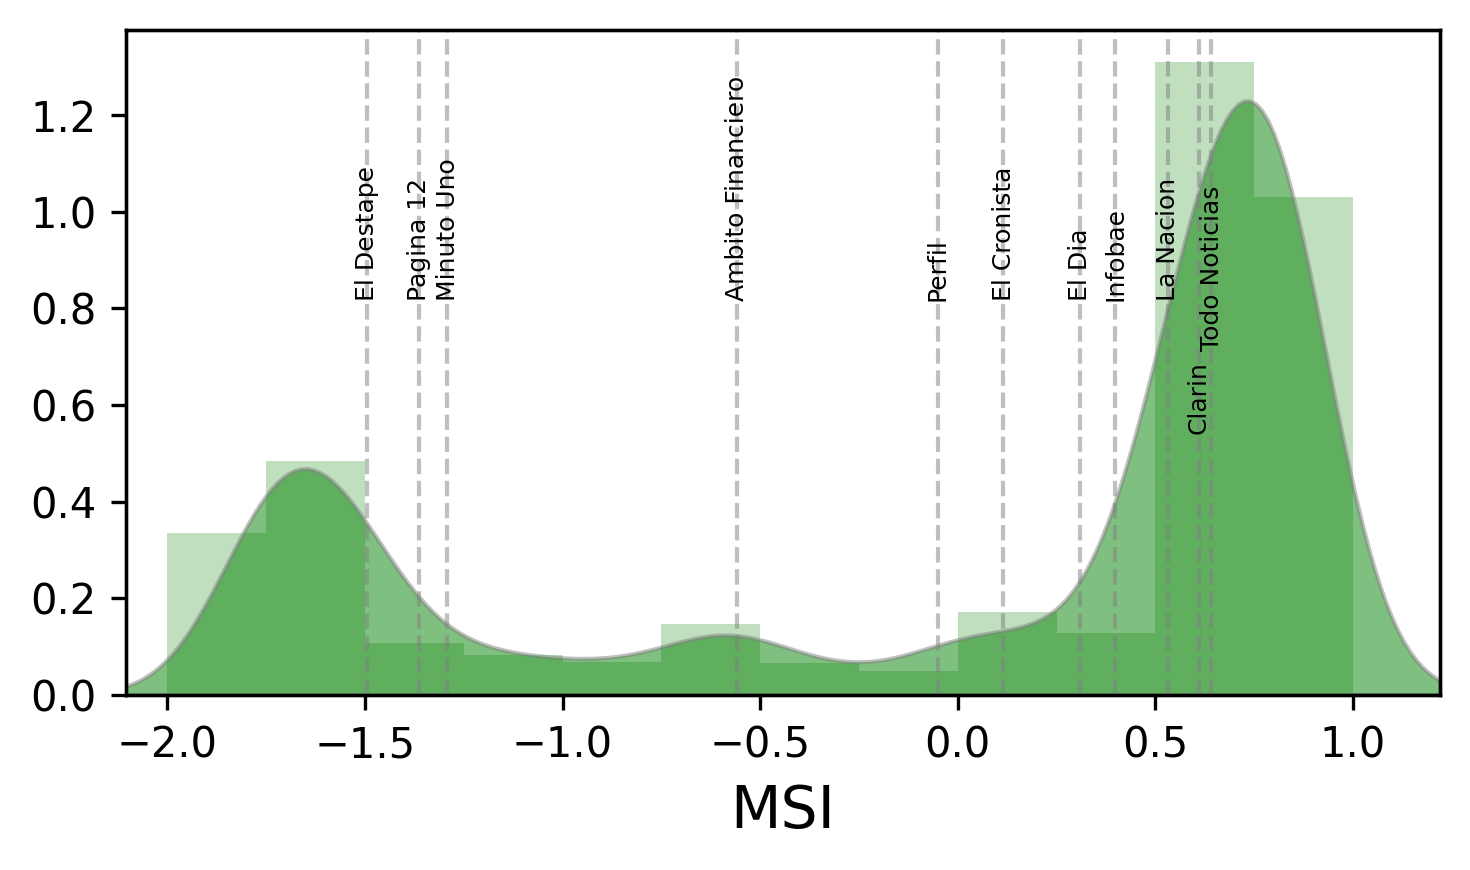

In [21]:
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))

# Histogram of the MSI of the users
ax.hist(score_users, bins = np.arange(-2, 2, 0.25), alpha = 0.25, color = 'g', density = True)

# Kernel estimation
kde.fit(score_users.reshape(-1,1))
x_hist = np.arange(-2.5, 2.51, 0.015)
score_users_hist = np.exp(kde.score_samples(x_hist.reshape(-1,1)))
ax.fill_between(x = x_hist, y1=0, y2=score_users_hist, color = 'g', alpha = 0.50, edgecolor = 'grey', linewidth = 1)

# MSI of media outlets
ax2 = ax.twinx()
for ms in zip(ppal_media, score_media):
    if ms[0] != 'Radio Mitre':
        ax2.axvline(ms[1], color = 'grey', alpha = 0.50, linestyle = '--', linewidth = 1)
        if ms[0] == 'Clarin':
            ax2.text(x = ms[1]-0.03, y = 0.40, s=ms[0], rotation = 90, size = 6)
        elif ms[0] == 'Todo Noticias':
            ax2.text(x = ms[1]-0.03, y = 0.525, s=ms[0], rotation = 90, size = 6)
        else: 
            ax2.text(x = ms[1]-0.03, y = 0.60, s=ms[0], rotation = 90, size = 6)

ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + np.array([-0.35, 0.35]))
ax.set_xlabel(r'MSI', size = 14)
ax.set_ylim(bottom = 0)

fig.tight_layout()

plt.savefig('Results/MSI.pdf')
plt.savefig('Results/MSI.png')

plt.show()

### Relation of the MSI with the ideology

We assign to each user the most frequent (the mode) ideological label and see the distribution of the MSI among the two main political groups.

In [14]:
from scipy.stats import mode 

# Calculation of the mode
user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])

# List of ideological label
ideology_of_msi_users = user_ideology[user_ideology.index.isin(user_media_df_filtered.index)].to_list()

# Append to the data
user_media_df_filtered['ideology'] = ideology_of_msi_users

/tmp/ipykernel_9758/1426920699.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])
/tmp/ipykernel_9758/1426920699.py:4: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])


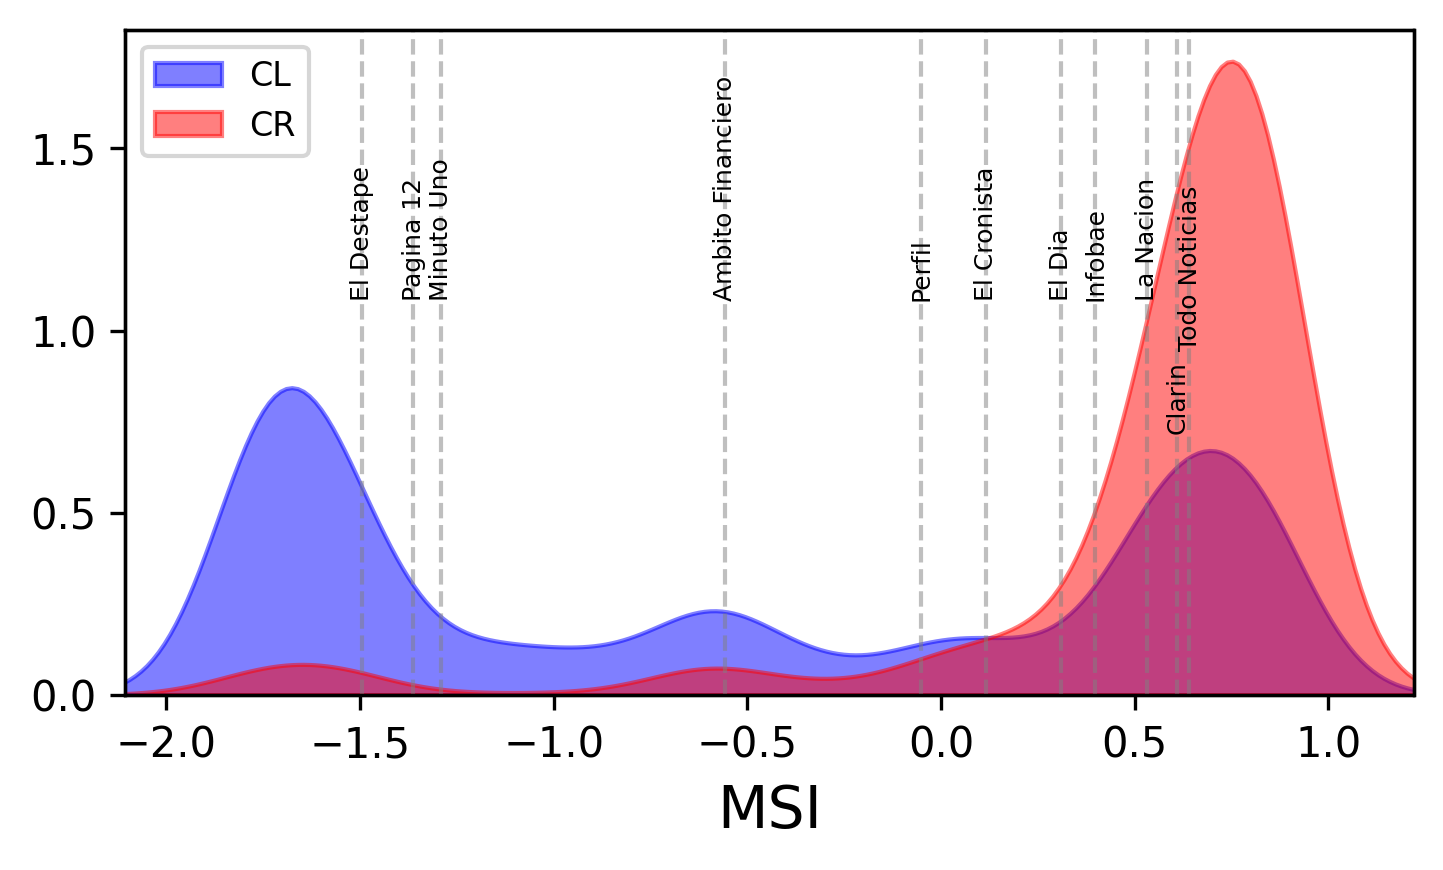

In [18]:
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))

ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:

    # MSI of the users of the group
    x = user_media_df_filtered[user_media_df_filtered['ideology'] == ideology]['score'].to_numpy()

    # Kernel density estimation
    kde.fit(x.reshape(-1,1))
    x_hist = np.arange(-2.5, 2.51, 0.015)
    score_users_hist = np.exp(kde.score_samples(x_hist.reshape(-1,1)))
    ax.fill_between(x = x_hist, y1=0, y2=score_users_hist, color = ideocolor[ideology], alpha = 0.50, edgecolor = ideocolor[ideology], linewidth = 1, label = (lambda x: 'CL' if x == 'FF' else 'CR')(ideology))

# MSI of media outlets
ax2 = ax.twinx()
for ms in zip(ppal_media, score_media):
    if ms[0] != 'Radio Mitre':
        ax2.axvline(ms[1], color = 'grey', alpha = 0.50, linestyle = '--', linewidth = 1)
        if ms[0] == 'Clarin':
            ax2.text(x = ms[1]-0.03, y = 0.40, s=ms[0], rotation = 90, size = 6)
        elif ms[0] == 'Todo Noticias':
            ax2.text(x = ms[1]-0.03, y = 0.525, s=ms[0], rotation = 90, size = 6)
        else: 
            ax2.text(x = ms[1]-0.03, y = 0.60, s=ms[0], rotation = 90, size = 6)

ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + np.array([-0.35, 0.35]))
ax.set_xlabel(r'MSI', size = 14)
ax.set_ylim(bottom=0)

ax.legend(loc = 'upper left', fontsize = 8)

fig.tight_layout()

plt.savefig('Results/MSI_ideology.pdf')
plt.savefig('Results/MSI_ideology.png')

plt.show()

Histograms without normalization:

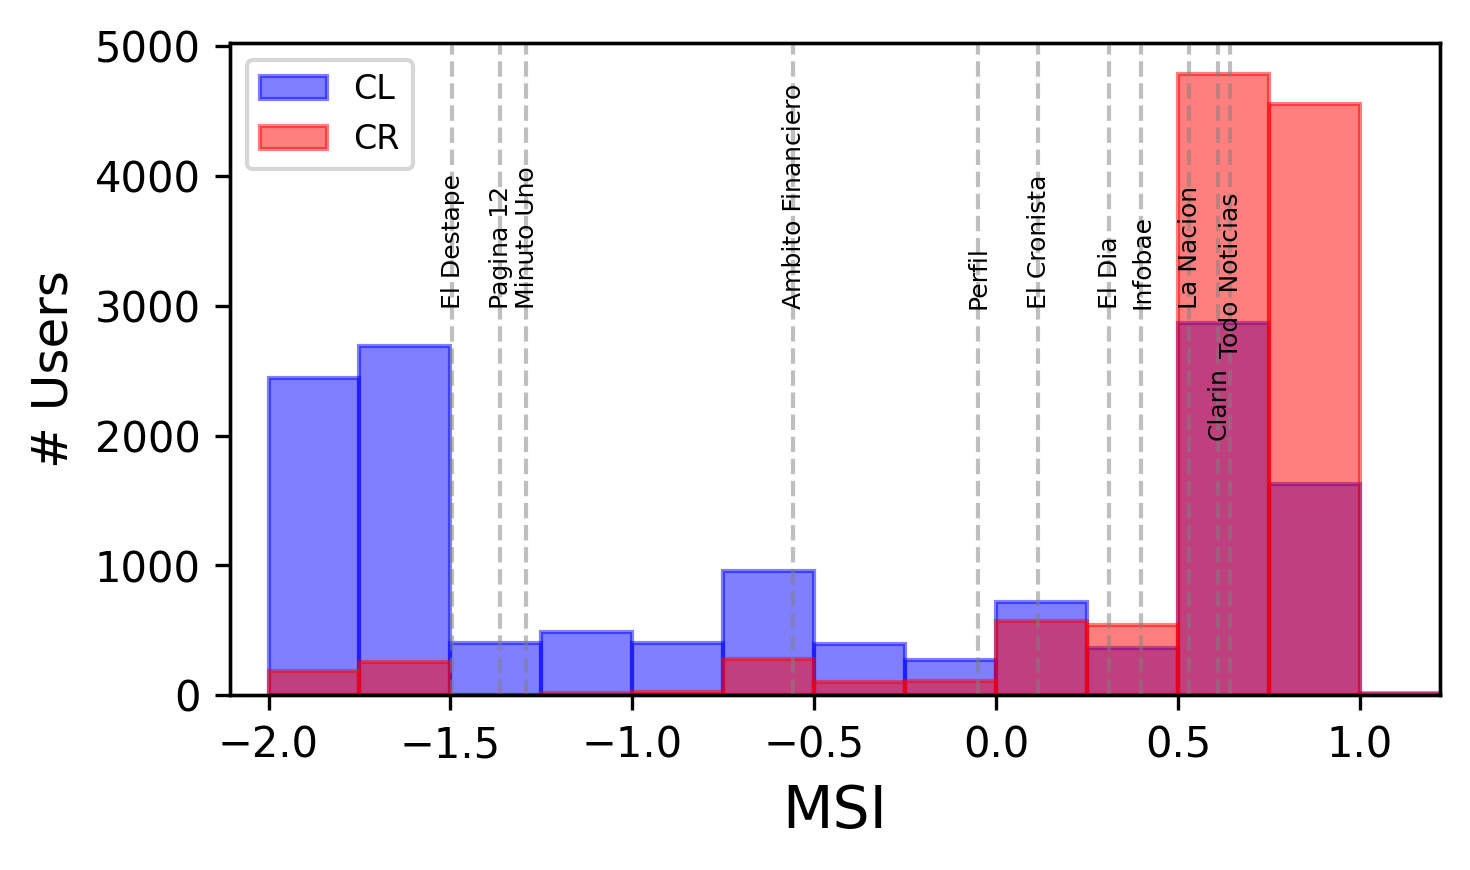

In [19]:
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))

ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:

    # MSI of the users of the group
    x = user_media_df_filtered[user_media_df_filtered['ideology'] == ideology]['score'].to_numpy()

    # Kernel density estimation
    ax.hist(x, bins = np.arange(-2, 2, 0.25), color = ideocolor[ideology], alpha = 0.50, edgecolor = ideocolor[ideology], linewidth = 1, label = (lambda x: 'CL' if x == 'FF' else 'CR')(ideology))

# MSI of media outlets
ax2 = ax.twinx()
for ms in zip(ppal_media, score_media):
    if ms[0] != 'Radio Mitre':
        ax2.axvline(ms[1], color = 'grey', alpha = 0.50, linestyle = '--', linewidth = 1)
        if ms[0] == 'Clarin':
            ax2.text(x = ms[1]-0.03, y = 0.40, s=ms[0], rotation = 90, size = 6)
        elif ms[0] == 'Todo Noticias':
            ax2.text(x = ms[1]-0.03, y = 0.525, s=ms[0], rotation = 90, size = 6)
        else: 
            ax2.text(x = ms[1]-0.03, y = 0.60, s=ms[0], rotation = 90, size = 6)

ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + np.array([-0.35, 0.35]))
ax.set_xlabel(r'MSI', size = 14)
ax.set_ylim(bottom=0)
ax.set_ylabel('# Users', size = 12)

ax.legend(loc = 'upper left', fontsize = 8)

fig.tight_layout()

plt.savefig('Results/MSI_ideology_number_of_users.pdf')
plt.savefig('Results/MSI_ideology_number_of_users.png')

plt.show()

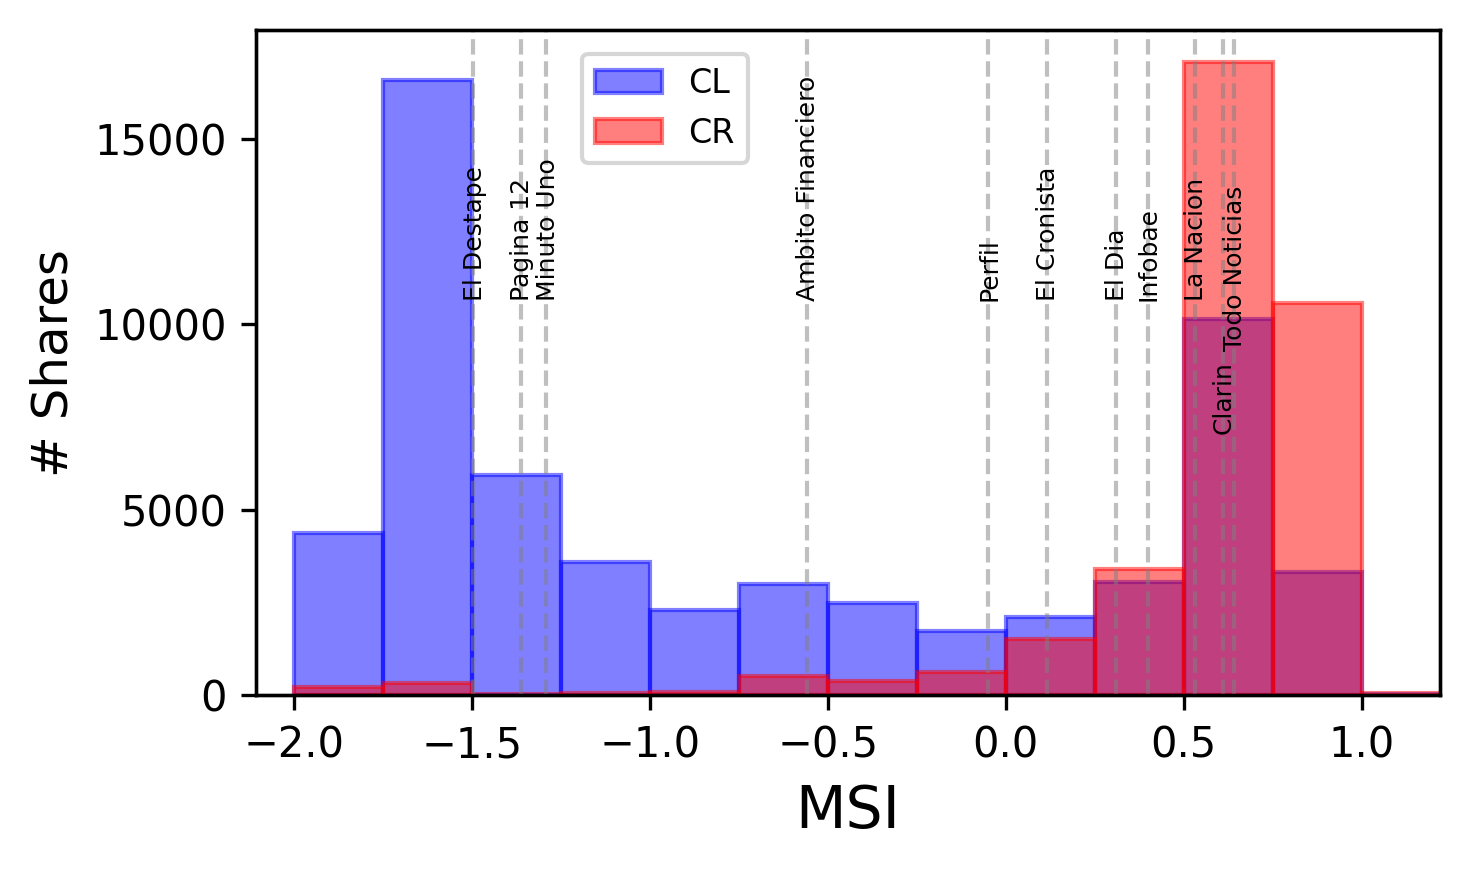

In [20]:
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))

ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:

    # MSI of the users of the group
    x = user_media_df_filtered[user_media_df_filtered['ideology'] == ideology]['score'].to_numpy()

    # Kernel density estimation
    ax.hist(x, bins = np.arange(-2, 2, 0.25), weights=user_media_df_filtered[user_media_df_filtered['ideology'] == ideology][user_media_df_filtered.columns[:12]].sum(axis = 1).to_numpy(),
            color = ideocolor[ideology], alpha = 0.50, edgecolor = ideocolor[ideology], linewidth = 1, label = (lambda x: 'CL' if x == 'FF' else 'CR')(ideology))

# MSI of media outlets
ax2 = ax.twinx()
for ms in zip(ppal_media, score_media):
    if ms[0] != 'Radio Mitre':
        ax2.axvline(ms[1], color = 'grey', alpha = 0.50, linestyle = '--', linewidth = 1)
        if ms[0] == 'Clarin':
            ax2.text(x = ms[1]-0.03, y = 0.40, s=ms[0], rotation = 90, size = 6)
        elif ms[0] == 'Todo Noticias':
            ax2.text(x = ms[1]-0.03, y = 0.525, s=ms[0], rotation = 90, size = 6)
        else: 
            ax2.text(x = ms[1]-0.03, y = 0.60, s=ms[0], rotation = 90, size = 6)

ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]) + np.array([-0.35, 0.35]))
ax.set_xlabel(r'MSI', size = 14)
ax.set_ylim(bottom=0)
ax.set_ylabel('# Shares', size = 12)

ax.legend(loc = (0.275, 0.8), fontsize = 8)

fig.tight_layout()

plt.savefig('Results/MSI_ideology_number_of_shares.pdf')
plt.savefig('Results/MSI_ideology_number_of_shares.png')

plt.show()